In [12]:
import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))

import pathlib
import pickle
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from Agents import QLearningAgent, BayesianQAgent, PSRLAgent, MomentMatchingAgent, UbeNoUnrollAgent
from Environments import DeepSea, WideNarrow, PriorMDP
from utils import solve_tabular_continuing_PI, run_experiment, run_oracle_experiment, load_agent

from tqdm import tqdm_notebook as tqdm

# For saving figures and agents
if not os.path.exists('results'): os.mkdir('results')
if not os.path.exists('results/figures'): os.mkdir('results/figures')
if not os.path.exists('results/agent_logs'): os.mkdir('results/agent_logs')

fig_loc = 'results/figures/'

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=50)

# Environment constants

In [13]:
# Widenarrow constants
num_time_steps = 5000
save_every = num_time_steps // 100
plot_time = 500

N = 1
W = 6

mu_l, mu_h = 0.0, 0.5
sig_l, sig_h = 1.0, 1.0

rew_params = ((mu_l, sig_l), (mu_h, sig_h), (mu_l, sig_l))
env_params = {'N'          : N,
              'W'          : W,
              'rew_params' : rew_params}

# Define environment
environment = WideNarrow(env_params)

# Number of PI steps and maximum buffer length (PSRL, UBE and MM only)
max_iter = 4 * N
max_buffer_length = 2 * N + 1

# Bayesian Q-Learning

In [14]:
# Agent parameters
agent_params = {'gamma'               : 0.9,
                'mu0'                 : 0.0,
                'lamda'               : 1.0,
                'alpha'               : 2.0,
                'beta'                : 2.0,
                'num_mixture_samples' : 1000,
                'sa_list'             : environment.sa_list()}

In [15]:
# for seed in tqdm(range(10)):

#     # Define agent
#     agent =  BayesianQAgent(agent_params)

#     # Run experiment
#     run_experiment(environment=environment,
#                    agent=agent,
#                    seed=seed,
#                    num_time_steps=num_time_steps,
#                    max_buffer_length=1,
#                    save_every=save_every)

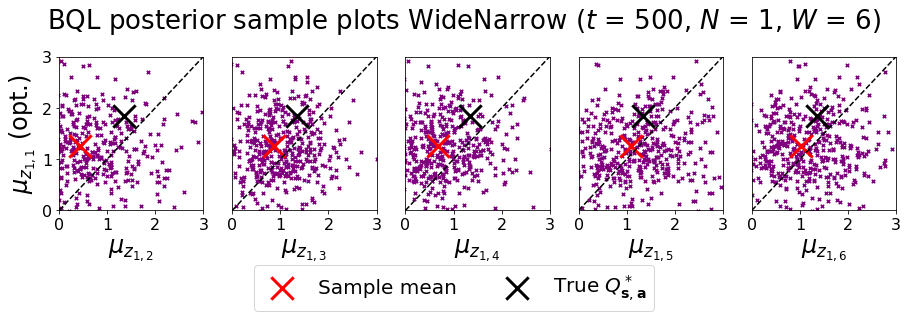

In [16]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, BayesianQAgent(agent_params), seed=1)
samples = []

leg_names = ['Sample mean',
             'True $Q^*_{\\mathbf{s}, \\mathbf{a}}$']
leg = [None] * 2

T = plot_time // save_every
for s in range(1):
    for i in range(500):

        environment.s = s

        agent.Qpost = agent.Qpost_log[T]
        samples.append(agent.take_action(s, 0, reduce_max=False)[0])
            
samples = np.array(samples)

fig = plt.figure(figsize=(15, 4.5))
for a in range(1, W):
    
    plt.subplot(1, W - 1, a)
    plt.scatter(samples[:, a], samples[:, 0], color='purple', marker='x', s=12)
    
    leg[0] = plt.scatter(samples[:, a].mean(), samples[:, 0].mean(), color='red', marker='x', s=500, linewidth=3)
    leg[1] = plt.scatter(Q[0, a], Q[0, 0], color='black', marker='x', s=500, linewidth=3)
    
    plt.plot(np.linspace(0, 3, 2), np.linspace(0, 3, 2), '--', color='black')
    
    plt.xlim([0, 3])
    plt.ylim([0, 3])
    
    plt.xlabel('$\mu_{z_{1, ' + str(a + 1) + '}}$', fontsize=24)
    
    if a == 1:
        plt.ylabel('$\mu_{z_{1, 1}}$ (opt.)', fontsize=24)
    else:
        plt.yticks([])

plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
title = 'BQL posterior sample plots WideNarrow ($t$ = {}, $N$ = {}, $W$ = {})'
plt.suptitle(title.format(plot_time, N, W), fontsize=26)
fig.subplots_adjust(top=0.825, bottom=0.35)

mu0, lamda, alpha, beta = agent.mu0, agent.lamda, agent.alpha, agent.beta
save_name = 'bql-{}-{}-{}-{}-scatter-widenarrow-{}-{}-{}'.format(mu0, lamda, alpha, beta, N, W, T)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# PSRL

In [17]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'max_iter'         : max_iter,
                'sa_list'          : environment.sa_list()}

In [18]:
# for seed in tqdm(range(10)):
    
#     # Define agent
#     agent = PSRLAgent(agent_params)

#     # Run experiment
#     run_experiment(environment=environment,
#                    agent=agent,
#                    seed=seed,
#                    num_time_steps=num_time_steps,
#                    max_buffer_length=max_buffer_length,
#                    save_every=save_every)

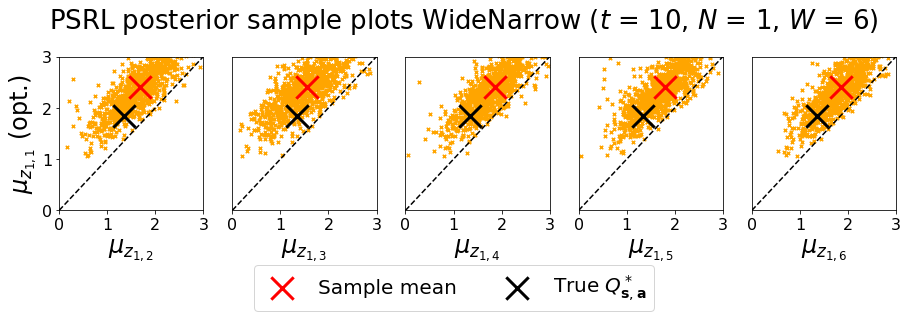

In [19]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, PSRLAgent(agent_params), seed=1)
samples = []

T = plot_time // save_every
for s in range(1):
    for i in range(1000):

        environment.s = s

        agent.Ppost = agent.Ppost_log[T]
        agent.Rpost = agent.Rpost_log[T]
        P, R = agent.sample_posterior()
        
        Q_ = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)[1]
        samples.append(Q_[0, :])
            
samples = np.array(samples)

fig = plt.figure(figsize=(15, 4.5))
for a in range(1, W):
    
    plt.subplot(1, W - 1, a)
    plt.scatter(samples[:, a], samples[:, 0], color='orange', marker='x', s=12)
    plt.scatter(samples[:, a].mean(), samples[:, 0].mean(), color='red', marker='x', s=500, linewidth=3)
    plt.scatter(Q[0, a], Q[0, 0], color='black', marker='x', s=500, linewidth=3)
    plt.plot(np.linspace(0, 3, 2), np.linspace(0, 3, 2), '--', color='black')
    
    plt.xlim([0, 3])
    plt.ylim([0, 3])
    
    plt.xlabel('$\mu_{z_{1, ' + str(a + 1) + '}}$', fontsize=24)
    
    if a == 1:
        plt.ylabel('$\mu_{z_{1, 1}}$ (opt.)', fontsize=24)
    else:
        plt.yticks([])
    

plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
title = 'PSRL posterior sample plots WideNarrow ($t$ = {}, $N$ = {}, $W$ = {})'
plt.suptitle(title.format(T, N, W), fontsize=26)
fig.subplots_adjust(top=0.825, bottom=0.35)

mu0, lamda, alpha, beta = agent.mu0, agent.lamda, agent.alpha, agent.beta
save_name = 'psrl-{}-{}-{}-{}-scatter-widenarrow-{}-{}-{}'.format(mu0, lamda, alpha, beta, N, W, T)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# UBE

In [20]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'Rmax'             : environment.get_mean_P_and_R()[1].max(),
                'max_iter'         : max_iter,
                'zeta'             : 1.0,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

In [21]:
# for seed in tqdm(range(10)):
    
#     # Define agent
#     agent = UbeNoUnrollAgent(agent_params)

#     # Run experiment
#     run_experiment(environment=environment,
#                    agent=agent,
#                    seed=seed,
#                    num_time_steps=num_time_steps,
#                    max_buffer_length=max_buffer_length,
#                    save_every=save_every)

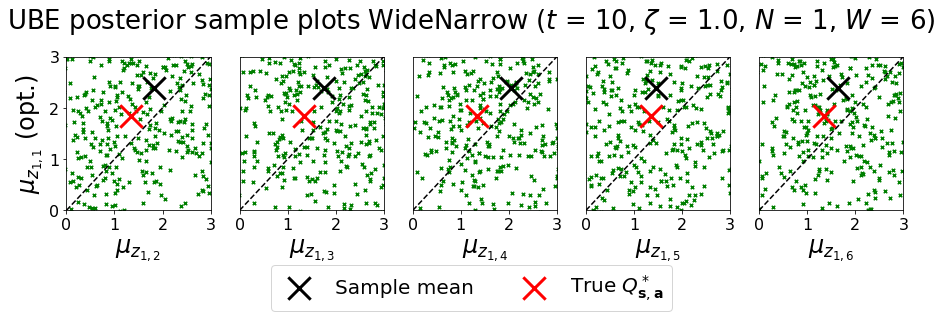

In [22]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=1)
samples = []

leg_names = ['Sample mean',
             'True $Q^*_{\\mathbf{s}, \\mathbf{a}}$']
leg = [None] * 2

T = plot_time // save_every
for s in range(1):

    Qmu = agent.Qmu_log[T]
    Qvar = agent.Qvar_log[T]
    
    for i in range(1000):

        environment.s = s
        samples.append(np.random.normal(Qmu[s, :], agent.zeta * Qvar[s, :]**0.5))
            
samples = np.array(samples)

fig = plt.figure(figsize=(15, 4.5))
for a in range(1, W):
    
    plt.subplot(1, W - 1, a)
    plt.scatter(samples[:, a], samples[:, 0], color='green', marker='x', s=12)
    leg[0] = plt.scatter(samples[:, a].mean(), samples[:, 0].mean(), color='black', marker='x', s=500, linewidth=3)
    leg[1] = plt.scatter(Q[0, a], Q[0, 0], color='red', marker='x', s=500, linewidth=3)
    plt.plot(np.linspace(0, 3, 2), np.linspace(0, 3, 2), '--', color='black')
    
    plt.xlim([0, 3])
    plt.ylim([0, 3])
    
    plt.xlabel('$\mu_{z_{1, ' + str(a + 1) + '}}$', fontsize=24)
    
    if a == 1:
        plt.ylabel('$\mu_{z_{1, 1}}$ (opt.)', fontsize=24)
    else:
        plt.yticks([])
    
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
title = 'UBE posterior sample plots WideNarrow ($t$ = {}, $\zeta$ = {}, $N$ = {}, $W$ = {})'
plt.suptitle(title.format(T, agent.zeta, N, W), fontsize=26)
fig.subplots_adjust(top=0.825, bottom=0.35)

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'ube-{}-{}-{}-{}-{}-scatter-widenarrow-{}-{}-{}'.format(mu0, lamda, alpha, beta, zeta, N, W, T)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# UBE

In [23]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'Rmax'             : environment.get_mean_P_and_R()[1].max(),
                'max_iter'         : max_iter,
                'zeta'             : 0.1,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

In [24]:
# for seed in tqdm(range(10)):

#     # Define agent
#     agent = UbeNoUnrollAgent(agent_params)

#     # Run experiment
#     run_experiment(environment=environment,
#                    agent=agent,
#                    seed=seed,
#                    num_time_steps=num_time_steps,
#                    max_buffer_length=max_buffer_length,
#                    save_every=save_every)

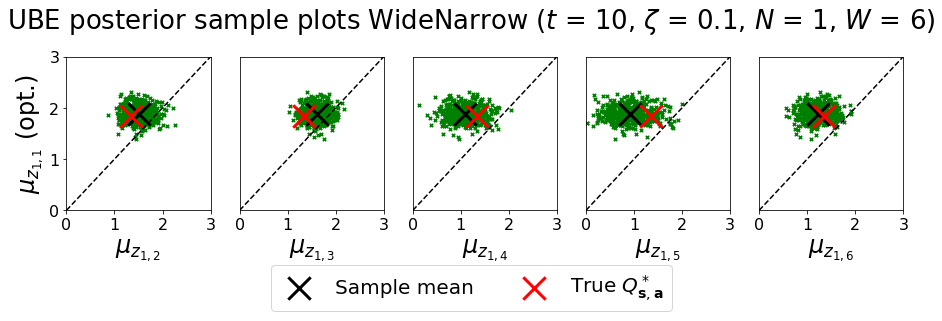

In [25]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=1)
samples = []

leg_names = ['Sample mean',
             'True $Q^*_{\\mathbf{s}, \\mathbf{a}}$']
leg = [None] * 2

T = plot_time // save_every
for s in range(1):

    Qmu = agent.Qmu_log[T]
    Qvar = agent.Qvar_log[T]
    
    for i in range(500):

        environment.s = s
        samples.append(np.random.normal(Qmu[s, :], agent.zeta * Qvar[s, :]**0.5))
            
samples = np.array(samples)

fig = plt.figure(figsize=(15, 4.5))
for a in range(1, W):
    
    plt.subplot(1, W - 1, a)
    plt.scatter(samples[:, a], samples[:, 0], color='green', marker='x', s=12)
    leg[0] = plt.scatter(samples[:, a].mean(), samples[:, 0].mean(), color='black', marker='x', s=500, linewidth=3)
    leg[1] = plt.scatter(Q[0, a], Q[0, 0], color='red', marker='x', s=500, linewidth=3)
    plt.plot(np.linspace(0, 3, 2), np.linspace(0, 3, 2), '--', color='black')
    
    plt.xlim([0, 3])
    plt.ylim([0, 3])
    
    plt.xlabel('$\mu_{z_{1, ' + str(a + 1) + '}}$', fontsize=24)
    
    if a == 1:
        plt.ylabel('$\mu_{z_{1, 1}}$ (opt.)', fontsize=24)
    else:
        plt.yticks([])
    
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
title = 'UBE posterior sample plots WideNarrow ($t$ = {}, $\zeta$ = {}, $N$ = {}, $W$ = {})'
plt.suptitle(title.format(T, agent.zeta, N, W), fontsize=26)
fig.subplots_adjust(top=0.825, bottom=0.35)

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'ube-{}-{}-{}-{}-{}-scatter-widenarrow-{}-{}-{}'.format(mu0, lamda, alpha, beta, zeta, N, W, T)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# Moment Matching

In [26]:
# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 1.0,
                'alpha'            : 2.0,
                'beta'             : 2.0,
                'max_iter'         : max_iter,
                'zeta'             : 1.0,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}

In [27]:
# for seed in tqdm(range(10)):

#     # Define agent
#     agent = MomentMatchingAgent(agent_params)

#     # Run experiment
#     run_experiment(environment=environment,
#                    agent=agent,
#                    seed=seed,
#                    num_time_steps=num_time_steps,
#                    max_buffer_length=max_buffer_length,
#                    save_every=save_every)

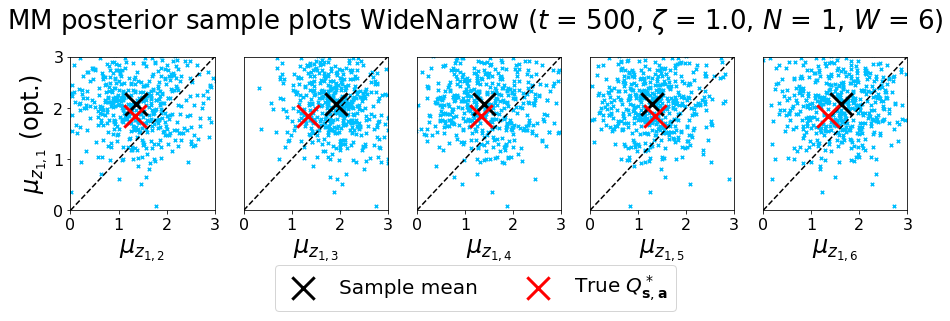

In [28]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, MomentMatchingAgent(agent_params), seed=1)
samples = []

leg_names = ['Sample mean',
             'True $Q^*_{\\mathbf{s}, \\mathbf{a}}$']
leg = [None] * 2

T = plot_time // save_every
for s in range(1):

    mu = agent.mu_log[T]
    var = agent.var_log[T]
    
    for i in range(500):

        environment.s = s
        samples.append(np.random.normal(mu[s, :], agent.zeta * var[s, :]**0.5))
            
samples = np.array(samples)

fig = plt.figure(figsize=(15, 4.5))
for a in range(1, W):
    
    plt.subplot(1, W - 1, a)
    plt.scatter(samples[:, a], samples[:, 0], color='deepskyblue', marker='x', s=12)
    leg[0] = plt.scatter(samples[:, a].mean(), samples[:, 0].mean(), color='black', marker='x', s=500, linewidth=3)
    leg[1] = plt.scatter(Q[0, a], Q[0, 0], color='red', marker='x', s=500, linewidth=3)
    plt.plot(np.linspace(0, 3, 2), np.linspace(0, 3, 2), '--', color='black')
    
    plt.xlim([0, 3])
    plt.ylim([0, 3])
    
    plt.xlabel('$\mu_{z_{1, ' + str(a + 1) + '}}$', fontsize=24)
    
    if a == 1:
        plt.ylabel('$\mu_{z_{1, 1}}$ (opt.)', fontsize=24)
    else:
        plt.yticks([])
    
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
title = 'MM posterior sample plots WideNarrow ($t$ = {}, $\zeta$ = {}, $N$ = {}, $W$ = {})'
plt.suptitle(title.format(plot_time, agent.zeta, N, W), fontsize=26)
fig.subplots_adjust(top=0.825, bottom=0.35)

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'mm-{}-{}-{}-{}-{}-scatter-widenarrow-{}-{}-{}'.format(mu0, lamda, alpha, beta, zeta, N, W, T)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()